# Introduction

# Preparatory analysis

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
data = pd.read_csv('data/diabetic_data.csv')

In [3]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Counting missing values for each feature

### Nan Values

In [4]:
data.shape

(101766, 50)

In [5]:
na_values = data.isna().sum(axis=0)

print(na_values[na_values > 0]/len(data) * 100)

max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64


Apparently, max_glu_serum and A1Cresults are the only features with 'Nan' values. We can easily drop these columns, as these features are categorical so they cannot be inferred in any way. 


In [6]:
data['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [7]:
data['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [8]:
data = data.drop(columns=['max_glu_serum', 'A1Cresult'])

### Other missing values

Taking a look at the datasaet, it is clear that for some features missing values are indicated by a question mark rathen than being nan values. Let's count missing values for each column

In [9]:
for col in data.columns:
    missing_values = data.loc[data[col] == '?', col].value_counts()
    if len(missing_values.values > 0):
        print(col, missing_values.values/len(data) * 100)

race [2.23355541]
weight [96.85847926]
payer_code [39.55741603]
medical_specialty [49.0822082]
diag_1 [0.02063558]
diag_2 [0.35178743]
diag_3 [1.39830592]


From the results above, we find that the feature 'weight' is available only for 3% of the observations! This column can be dropped. We also find that 49% of observations do not have values for medical_speciality and 39% do not have values for payer_code. These two are both categorical variables, so we cannot use the mean or other statistics to replace missing values. So, they can easily be dropped
diag_1, diag_2 and diag_3 are diagnosis so they cannot be inferred. In a classification setting these features can cleary be useful. Suppose the primary diagnosis is correct: intuitevely, a patient with a correct diagnosis has a less probability of returning to the hospital rather than a patient with n incorrect diaagnosis. Rather than drop the columns it is wiser to drop the observations with missing diagnosis.

In [10]:
data = data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

In [11]:
#FARLO DOPO ANALISI ESPLORATIVA, ALTRIMENTI ALCUNE OSSERVAZIONI UTILI SI PERDONO

#labels = (data['diag_1'] == '?') | (data['diag_2'] == '?') | (data['diag_3'] == '?')
#data.drop(data[labels].index, inplace=True) # data[~labels] OP

In [12]:
data.shape

(101766, 45)

In [13]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data is now ready for the analysis pipeline!

## Changing unique values for some columns

Is this safe for logistic regression?

In [14]:
data.replace(['NO', '>30', '<30'], [0, 1, 2], inplace=True)
data.replace('No', 0, inplace=True)
data.replace('Ch', 1, inplace=True)
data.replace('Yes', 1, inplace=True)
data.replace(['Steady', 'Up', 'Down'], [1, 2, 3], inplace=True) #non ottimale

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_13928\3821934187.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(['NO', '>30', '<30'], [0, 1, 2], inplace=True)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_13928\3821934187.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('No', 0, inplace=True)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_13928\3821934187.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explic

In [15]:
data

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,0,2,0,0,0,0,0,1,1,1
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,0,0,0,0,0,0,0,0,1,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,0,2,0,0,0,0,0,1,1,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),1,3,7,3,51,...,0,3,0,0,0,0,0,1,1,1
101762,443847782,74694222,AfricanAmerican,Female,[80-90),1,4,5,5,33,...,0,1,0,0,0,0,0,0,1,0
101763,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,53,...,0,3,0,0,0,0,0,1,1,0
101764,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,45,...,0,2,0,0,0,0,0,1,1,0


In [16]:
data['readmitted'] = pd.to_numeric(data['readmitted'])
data['change'] = pd.to_numeric(data['change'])
data['diabetesMed'] = pd.to_numeric(data['diabetesMed'])

#...

# Exploratory data analysis

## What is the most frequent readmission type?

In [17]:
freqs = data['readmitted'].value_counts(normalize=True).sort_index()
print(freqs)

readmitted
0    0.539119
1    0.349282
2    0.111599
Name: proportion, dtype: float64


<Axes: xlabel='readmitted'>

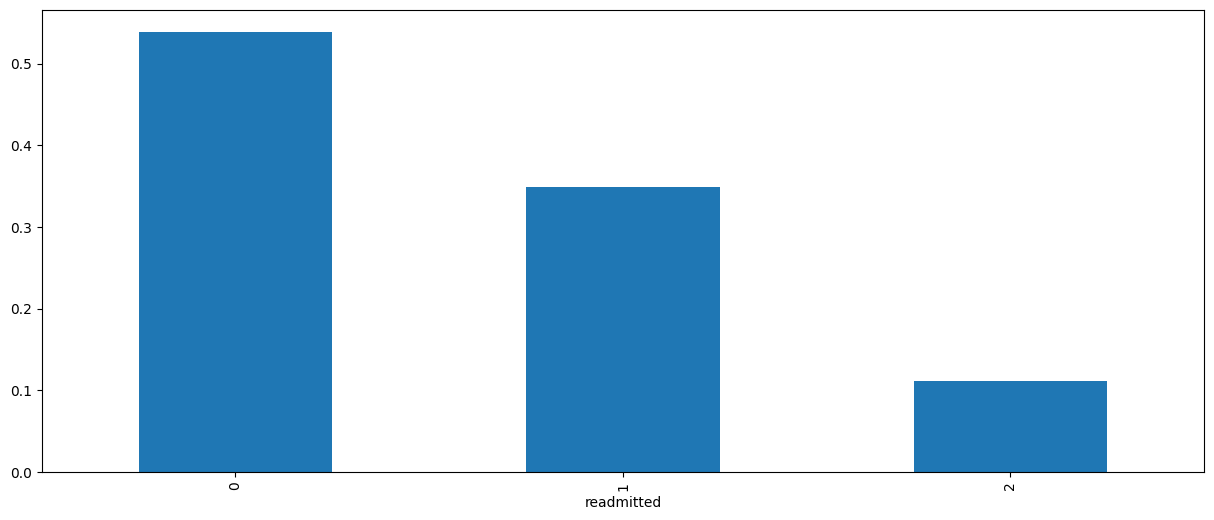

In [18]:
freqs.plot.bar(figsize=(15, 6))

Il 54% dei pazienti non è tornato in ospedale, il 35% è tornato in ospedale in un periodo che supera i 30 giorni e, infine, il restante 11% è tornato entro i 30 giorni. Da questo si evince che le valutazioni effettuate dai medici su #num pazienti si sono rivelate corrette e senza falle. ??

In [19]:
#data['readmitted'].plot.bar()

# Question 2: what is the distribution of gender between readmissions?

## Distribution of gender

In [22]:
data['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [28]:
freqs = data['gender'].value_counts(normalize=True)
print(freqs)

gender
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: proportion, dtype: float64


<Axes: xlabel='gender'>

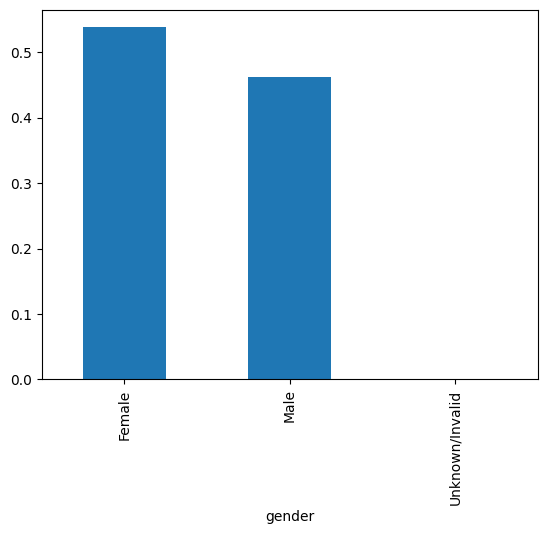

In [29]:
freqs.plot.bar()

Let's count how many patients with 'unknown/invalid' gender are there in the dataset

In [31]:
data['gender'].value_counts().sort_index()

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

# Distribution of gender between readmissions

In [51]:
d = data[['gender', 'readmitted']]

freqs = (d.groupby('gender').value_counts(normalize=True))
print(freqs)

gender           readmitted
Female           0             0.530782
                 1             0.356767
                 2             0.112452
Male             0             0.548783
                 1             0.340601
                 2             0.110615
Unknown/Invalid  0             1.000000
Name: proportion, dtype: float64


<Axes: xlabel='gender,readmitted'>

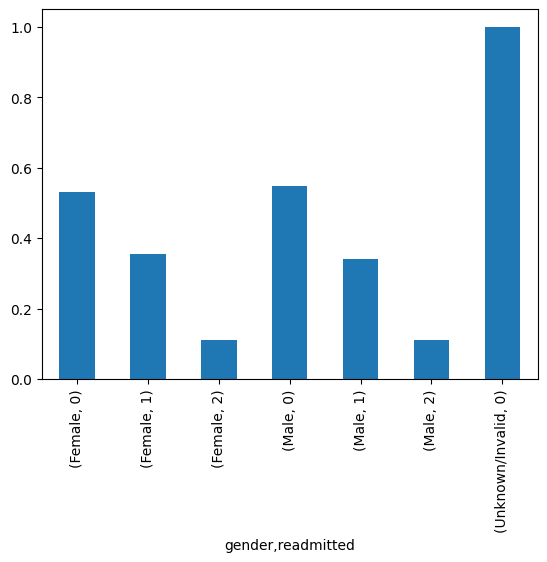

In [52]:
freqs.plot.bar()

....

# What is the average time in hospital?

In [80]:
mean = data['time_in_hospital'].mean()
print(mean)

4.395986871843248


From the results above, we find that the average time in hospital is 4 days. Is this due to chance or is it statistically significant? Let's run a statistical test and find out.

In [92]:
t, p = stats.ttest_1samp(data['time_in_hospital'], mean)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.0 
Alpha:  0.05


The p value is greater than the significance level, so we cannot reject the null hypothesis. <br>
This means that data do not provide enough evidence to say that the true time in hospital differs from 4 and an half day.

# What is the average time in hospital between readmission classes?

In [87]:
not_readmitted = data.loc[data['readmitted'] == 0, 'time_in_hospital']
mean_not_readmitted = not_readmitted.mean()
print(mean_not_readmitted)

4.254429133858268


In [88]:
readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital']
mean_readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital'].mean()
print(mean_readmitted)

4.56157519935184


Again, is this due to chance or is it statistically significant? Let's run a statistical test to see if we can reject the hypothesis that the two means are equal. 

In [93]:
t, p = stats.ttest_ind(readmitted, not_readmitted)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  3.023396538894888e-60 
Alpha:  0.05


We can reject the null hyphothesis. It is safe to say that the two populations mean are different. 
Let's study the relationship between time_in_hospital and readmitted, using logistic regression.

# Logistic regression

Let's fit a logistic regressor to find if there is any relationship between time_in_hospital and readmitted.

In [105]:
data['readmitted'].unique()

array([0, 1, 2])

In [107]:
from statsmodels.formula.api import logit, mnlogit

In [114]:
model = mnlogit('readmitted ~ time_in_hospital', data).fit()

Optimization terminated successfully.
         Current function value: 0.943557
         Iterations 6


Domande

Distribuzione del sesso tra le riamissioni

Tempo medio in ospedale: test statistico

weight numero valori mancanti e unici

"race" presente: valori unici

distribuzione diabetes med readmitted

distribuzione race

Feature engineering

readmisssions 0 1 2
change: 0 -> 1
tutte le altre colonne

# Methods

# Results

# Conclusions